In [1]:
import numpy as np
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt
import librosa as lb
import os.path
from pathlib import Path
import pickle
import multiprocessing
import time
import gc
from numba import jit, njit, typeof
import linmdtw
from gpuAlign import *

In [2]:
linmTimes = pickle.load(open(Path("timings/linmdtwTimings"), 'rb'))

In [3]:
linmTime = np.average(linmTimes)

In [4]:
CdSBTimes = pickle.load(open(Path("timings/CdSB"), 'rb'))

In [5]:
CdSBTime = np.average(np.sum(CdSBTimes, axis = 1))

In [6]:
cdSBTimes = pickle.load(open(Path("timings/cdSB"), 'rb'))

In [7]:
cdSBTime = np.average(np.sum(cdSBTimes, axis = 1))

In [8]:
CdSbTimes = pickle.load(open(Path("timings/CdSb"), 'rb'))

In [9]:
CdSbTime = np.average(np.sum(CdSbTimes, axis = 1))

In [10]:
cdSbTimes = pickle.load(open(Path("timings/cdSb"), 'rb'))

In [11]:
cdSbTime = np.average(np.sum(cdSbTimes, axis = 1))

In [12]:
cdSbV2Times = pickle.load(open(Path("timings/cdSb_V2"), 'rb'))

In [13]:
cdSbV2Time = np.average(np.sum(cdSbV2Times, axis = 1))

In [14]:
CDSBTimes = pickle.load(open(Path("timings/CDSB"), 'rb'))

In [15]:
CDSBTime = np.average(np.sum(CDSBTimes, axis = 1))

In [16]:
DTWTimes = pickle.load(open(Path("timings/DTW"), 'rb'))

In [17]:
DTWTime = np.average(np.sum(DTWTimes, axis = 1))

In [18]:
lbDTWTimes = pickle.load(open(Path("timings/lbDTW"), 'rb'))

In [19]:
lbDTWTime = np.average(lbDTWTimes)

In [20]:
print("linear memory: ", linmTime)
print("CdSB: ", CdSBTime)
print("cdSB: ", cdSBTime)
print("CdSb: ", CdSbTime)
print("cdSb: ", cdSbTime)
print("cdSb V2: ", cdSbV2Time)
print("CDSB: ", CDSBTime)
print("DTW: ", DTWTime)
print("Librosa DTW: ", lbDTWTime)

linear memory:  6.579968018531799
CdSB:  2.2307140851020812
cdSB:  1.8891599988937378
CdSb:  2.031978132724762
cdSb:  1.737469413280487
cdSb V2:  1.601242139339447
CDSB:  2.2721242356300353
DTW:  3.7672531962394715
Librosa DTW:  6.334135558605194


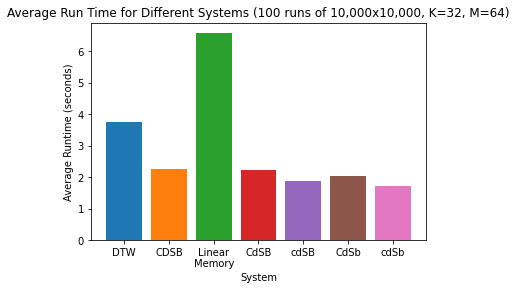

In [21]:
toPlot = [DTWTime, CDSBTime, linmTime, CdSBTime, cdSBTime, CdSbTime, cdSbTime]
labels = ["DTW", "CDSB", "Linear\nMemory", "CdSB", "cdSB", "CdSb", "cdSb"]
for i, theTime in enumerate(toPlot):
    plt.bar(i, theTime)

plt.xticks(list(range(len(labels))), labels);
plt.xlabel("System")
plt.ylabel("Average Runtime (seconds)")
plt.title("Average Run Time for Different Systems (100 runs of 10,000x10,000, K=32, M=64)");

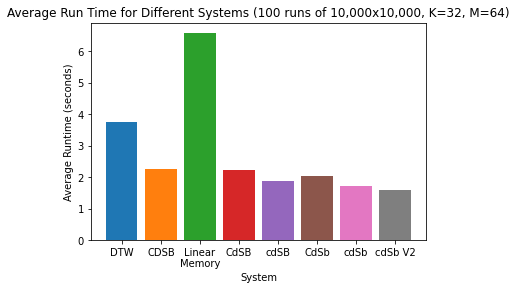

In [22]:
toPlot = [DTWTime, CDSBTime, linmTime, CdSBTime, cdSBTime, CdSbTime, cdSbTime, cdSbV2Time]
labels = ["DTW", "CDSB", "Linear\nMemory", "CdSB", "cdSB", "CdSb", "cdSb", "cdSb V2"]
for i, time in enumerate(toPlot):
    plt.bar(i, time)

plt.xticks(list(range(len(labels))), labels);
plt.xlabel("System")
plt.ylabel("Average Runtime (seconds)")
plt.title("Average Run Time for Different Systems (100 runs of 10,000x10,000, K=32, M=64)");

In [34]:
CDSBToPlot = np.zeros(5)
CDSBAvgs = np.average(CDSBTimes, axis = 0)
CDSBToPlot[0:4] = CDSBAvgs[0:4]
CDSBToPlot[3] += CDSBAvgs[4]
CDSBToPlot[4] = CDSBAvgs[-1]

In [24]:
np.sum(np.average(CDSBTimes[:,2:5]), axis = 0)

0.002423420747121175

In [35]:
DTWAvgs = np.average(DTWTimes, axis = 0)
DTWToPlot = np.array([DTWAvgs[0], DTWAvgs[1], 0, 0, DTWAvgs[2]])

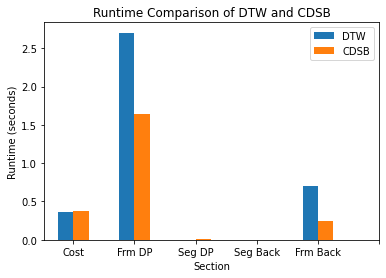

In [40]:
width = 0.25
plt.bar(np.arange(len(CDSBToPlot)) - 0.125, DTWToPlot, width);
plt.bar(np.arange(len(CDSBToPlot)) + 0.125, CDSBToPlot, width);
plt.xticks(np.arange(len(CDSBAvgs)), ["Cost", "Frm DP", "Seg DP", "Seg Back", "Frm Back"]);
plt.legend(["DTW", "CDSB"]);
plt.title("Runtime Comparison of DTW and CDSB");
plt.ylabel("Runtime (seconds)");
plt.xlabel("Section");

In [26]:
def plotPie(labels, proportions, title):
    plt.pie(proportions, labels = labels, autopct='%1.2f%%');
    plt.title(title)

# CdSB

In [27]:
labels = ['DTW kernel', 'Host to Device Transfer', 'Device to Host Transfer', 'CPU Work']
proportions = np.array([0.9467, 0.179, 0.4564, CdSBTime-0.9467-0.179-0.4564]) / CdSbTime

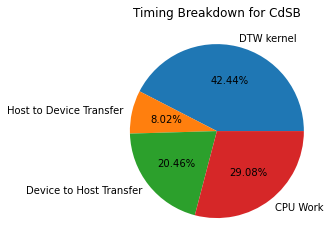

In [28]:
plotPie(labels, proportions, "Timing Breakdown for CdSB")

# cdSB

In [29]:
labels = ['Cost & DTW kernel', 'Host to Device Transfer', 'Device to Host Transfer', "CPU Work"]
proportions = np.array([1.1768, 0.00016, 0.4606, cdSBTime-1.1768-0.00016-0.4606]) / cdSBTime

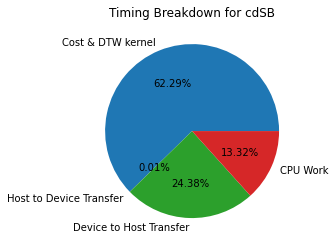

In [30]:
plotPie(labels, proportions, "Timing Breakdown for cdSB")

# CdSb

In [31]:
labels = ['DTW kernel', 'Host to Device Transfer', 'Device to Host Transfer', 'CPU Work', 'Backtrace Kernel']
proportions = np.array([0.9539, 0.176686, 0.4541, CdSbTime-0.9539-0.176686-0.4541-0.0002, 0.0002]) / CdSbTime

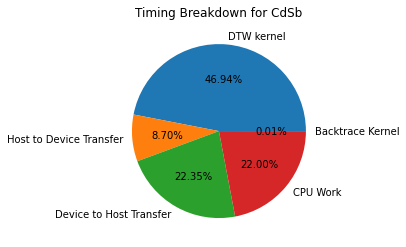

In [32]:
plotPie(labels, proportions, "Timing Breakdown for CdSb")

# cdSb

In [33]:
labels = ['DTW & Cost kernel', 'Host to Device Transfer', 'Device to Host Transfer', 'CPU Work', 'Backtrace Kernel']
proportions = np.array([1.1708, 0.000162, 0.482, cdSbTime-1.1708-0.000162-0.482-0.000206, 0.000206]) / cdSbTime

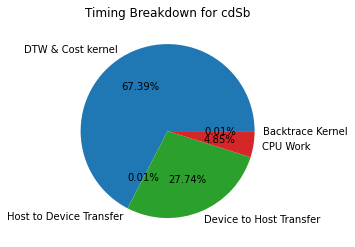

In [34]:
plotPie(labels, proportions, "Timing Breakdown for cdSb")

# Linear Memory

In [35]:
labels = ['DTW kernel', 'Other', 'CPU Work']
proportions = ([0.60842, 0.00137, linmTime-0.60842-0.00137]) / linmTime

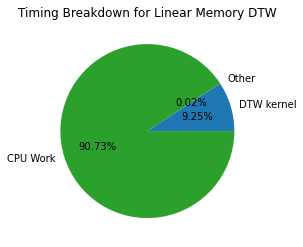

In [36]:
plotPie(labels, proportions, "Timing Breakdown for Linear Memory DTW")

# cdSb V2

In [37]:
labels = ['DTW kernel', 'Host to Device Transfer', 'Device to Host Transfer', 'Backtrace Kernel']
proportions = [0.7728, 0.0001, 0.2269, 0.0001]

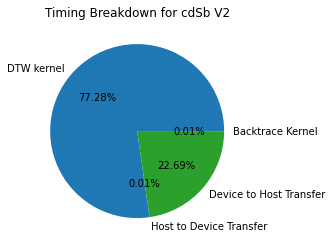

In [38]:
plotPie(labels, proportions, "Timing Breakdown for cdSb V2")

# CDSB vs DTW

In [2]:
seq_len = 10000

In [24]:
seq_len = 10000
F1 = np.abs(np.random.randn(12, seq_len))
F1 = F1 / np.linalg.norm(F1, axis = 1, keepdims=True)
F2 = np.abs(np.random.randn(12, seq_len))
F2 = F2 / np.linalg.norm(F2, axis = 1, keepdims=True)
C = 1 - F1.T @ F2 
D,B = DTW_Cost_To_DandB(C)
K_vals = [1, 2, 4, 8, 16, 32, 64, 128]
dividedTimes = np.zeros((8, 10))
for k, K in enumerate(K_vals):
    print(K)
    for i in range(10):
        segLength = int(np.ceil(seq_len / K))
        thisTime = 0
        for j in range(K):
            F1 = np.abs(np.random.randn(12, segLength))
            F1 = F1 / np.linalg.norm(F1, axis = 1, keepdims=True)
            F2 = np.abs(np.random.randn(12, seq_len))
            F2 = F2 / np.linalg.norm(F2, axis = 1, keepdims=True)
            C = 1 - F1.T @ F2 
            timeStart = time.time()
            _ = DTW_Cost_To_DandB(C, subsequence = True)
            timeStop = time.time()
            thisTime += timeStop - timeStart
        dividedTimes[k, i] = thisTime

1
2
4
8
16
32
64
128


In [25]:
np.average(dividedTimes, axis = 1)

array([1.67728603, 1.71796358, 1.79496398, 1.9273371 , 1.92840855,
       1.17650292, 0.91691966, 0.93769703])

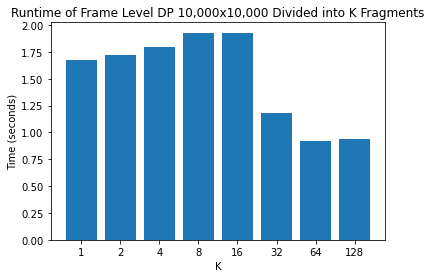

In [26]:
plt.bar(np.arange(8), np.average(dividedTimes, axis = 1));
plt.xticks(np.arange(8), K_vals);
plt.xlabel("K");
plt.ylabel("Time (seconds)");
plt.title("Runtime of Frame Level DP 10,000x10,000 Divided into K Fragments");

In [18]:
seq_len = 10000
F1 = np.abs(np.random.randn(12, seq_len))
F1 = F1 / np.linalg.norm(F1, axis = 1, keepdims=True)
F2 = np.abs(np.random.randn(12, seq_len))
F2 = F2 / np.linalg.norm(F2, axis = 1, keepdims=True)
C = 1 - F1.T @ F2 
_ = DTW_Cost_To_DandB(C)
K_vals2 = list(range(16, 33))
dividedTimes2 = np.zeros((len(K_vals2), 10))
for k, K in enumerate(K_vals2):
    print(K)
    for i in range(10):
        segLength = int(np.ceil(seq_len / K))
        thisTime = 0
        for j in range(K):
            F1 = np.abs(np.random.randn(12, segLength))
            F1 = F1 / np.linalg.norm(F1, axis = 1, keepdims=True)
            F2 = np.abs(np.random.randn(12, seq_len))
            F2 = F2 / np.linalg.norm(F2, axis = 1, keepdims=True)
            C = 1 - F1.T @ F2 
            timeStart = time.time()
            _ = DTW_Cost_To_DandB(C, subsequence = True)
            timeStop = time.time()
            thisTime += timeStop - timeStart
        dividedTimes2[k, i] = thisTime

16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


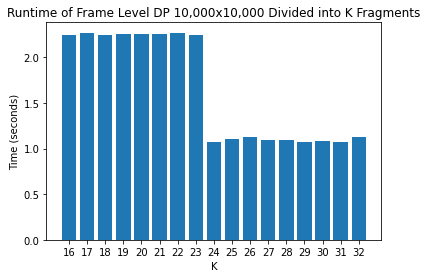

In [19]:
plt.bar(np.arange(len(K_vals2)), np.average(dividedTimes2, axis = 1));
plt.xticks(np.arange(len(K_vals2)), K_vals2);
plt.xlabel("K");
plt.ylabel("Time (seconds)");
plt.title("Runtime of Frame Level DP 10,000x10,000 Divided into K Fragments");

In [20]:
np.average(dividedTimes2, axis = 1)

array([2.24891009, 2.2667974 , 2.24915898, 2.25279391, 2.25581343,
       2.25949631, 2.26951058, 2.24273214, 1.0718596 , 1.10225065,
       1.13193617, 1.09177127, 1.09634531, 1.0704638 , 1.08792078,
       1.06755261, 1.12833414])

In [21]:
dividedTimes2[0,:]

array([2.30671287, 2.24672246, 2.24703526, 2.23997712, 2.24517059,
       2.23497248, 2.26520872, 2.22849703, 2.23932886, 2.23547554])

In [22]:
seq_len = 5000
F1 = np.abs(np.random.randn(12, seq_len))
F1 = F1 / np.linalg.norm(F1, axis = 1, keepdims=True)
F2 = np.abs(np.random.randn(12, seq_len))
F2 = F2 / np.linalg.norm(F2, axis = 1, keepdims=True)
C = 1 - F1.T @ F2 
_ = DTW_Cost_To_DandB(C)
K_vals3 = K_vals
dividedTimes3 = np.zeros((len(K_vals3), 10))
for k, K in enumerate(K_vals3):
    print(K)
    for i in range(10):
        segLength = int(np.ceil(seq_len / K))
        thisTime = 0
        for j in range(K):
            F1 = np.abs(np.random.randn(12, segLength))
            F1 = F1 / np.linalg.norm(F1, axis = 1, keepdims=True)
            F2 = np.abs(np.random.randn(12, seq_len))
            F2 = F2 / np.linalg.norm(F2, axis = 1, keepdims=True)
            C = 1 - F1.T @ F2 
            timeStart = time.time()
            _ = DTW_Cost_To_DandB(C, subsequence = True)
            timeStop = time.time()
            thisTime += timeStop - timeStart
        dividedTimes3[k, i] = thisTime

1
2
4
8
16
32
64
128


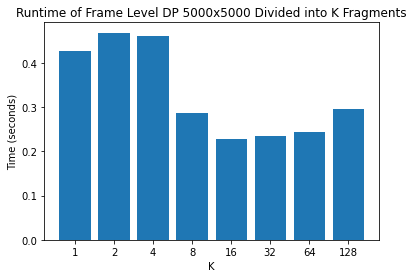

In [23]:
plt.bar(np.arange(len(K_vals3)), np.average(dividedTimes3, axis = 1));
plt.xticks(np.arange(len(K_vals3)), K_vals3);
plt.xlabel("K");
plt.ylabel("Time (seconds)");
plt.title("Runtime of Frame Level DP 5000x5000 Divided into K Fragments");

In [27]:
seq_len = 5000
F1 = np.abs(np.random.randn(12, seq_len))
F1 = F1 / np.linalg.norm(F1, axis = 1, keepdims=True)
F2 = np.abs(np.random.randn(12, seq_len))
F2 = F2 / np.linalg.norm(F2, axis = 1, keepdims=True)
C = 1 - F1.T @ F2 
_ = DTW_Cost_To_DandB(C)
K_vals4 = list(range(4, 9))
dividedTimes4 = np.zeros((len(K_vals4), 10))
for k, K in enumerate(K_vals4):
    print(K)
    for i in range(10):
        segLength = int(np.ceil(seq_len / K))
        thisTime = 0
        for j in range(K):
            F1 = np.abs(np.random.randn(12, segLength))
            F1 = F1 / np.linalg.norm(F1, axis = 1, keepdims=True)
            F2 = np.abs(np.random.randn(12, seq_len))
            F2 = F2 / np.linalg.norm(F2, axis = 1, keepdims=True)
            C = 1 - F1.T @ F2 
            timeStart = time.time()
            _ = DTW_Cost_To_DandB(C, subsequence = True)
            timeStop = time.time()
            thisTime += timeStop - timeStart
        dividedTimes4[k, i] = thisTime

4
5
6
7
8


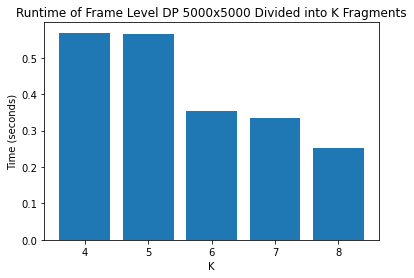

In [28]:
plt.bar(np.arange(len(K_vals4)), np.average(dividedTimes4, axis = 1));
plt.xticks(np.arange(len(K_vals4)), K_vals4);
plt.xlabel("K");
plt.ylabel("Time (seconds)");
plt.title("Runtime of Frame Level DP 5000x5000 Divided into K Fragments");

In [54]:
subseqDTWDefaultSteps = np.array([[1, 1, 2],
                                  [1, 2, 1]], dtype = np.float64)

subseqDTWDefaultWeights = np.array([1, 1, 2], dtype = np.float64)

seq_len = 10000
F1 = np.abs(np.random.randn(12, seq_len))
F1 = F1 / np.linalg.norm(F1, axis = 1, keepdims=True)
F2 = np.abs(np.random.randn(12, seq_len))
F2 = F2 / np.linalg.norm(F2, axis = 1, keepdims=True)
C = 1 - F1.T @ F2 
D,B = DTW_Cost_To_DandB(C)
K_vals = [1, 2, 4, 8, 16, 32, 64, 128]
dividedTimes = np.zeros((8, 10))
for k, K in enumerate(K_vals):
    print(K)
    for i in range(10):
        segLength = int(np.ceil(seq_len / K))
        B_i = B[:segLength,:]
        D_i = D[:segLength,:]
        thisTime = 0
        for j in range(K):
            timeStart = time.time()
            _ = DTW_Backtrace(D_i, B_i, Steps = subseqDTWDefaultSteps, subsequence = True)
            timeStop = time.time()
            thisTime += timeStop - timeStart
        dividedTimes[k, i] = thisTime

1
2
4
8
16
32
64
128


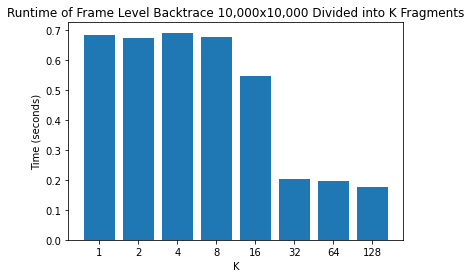

In [55]:
plt.bar(np.arange(8), np.average(dividedTimes, axis = 1));
plt.xticks(np.arange(8), K_vals);
plt.xlabel("K");
plt.ylabel("Time (seconds)");
plt.title("Runtime of Frame Level Backtrace 10,000x10,000 Divided into K Fragments");

# Q2: DP on CPU vs GPU

In [55]:
N_vals = [1000, 2000, 5000, 10000]

In [56]:
# Read in manually from nvprof results
GPU_Times = [1.05666, 4.21193, 27.1896, 106.987]

In [57]:
CPU_Times = []
for N in N_vals:
    try:
        timeArr = pickle.load(open(Path("timings/DP_%s" % str(N)), 'rb'))
        CPU_Times.append(np.average(timeArr))
    except:
        print("File Not Found: timings/DP_" + str(N))

In [58]:
CPU_Times

[0.02632256507873535,
 0.09536650657653808,
 0.6296599435806275,
 2.45747211933136]

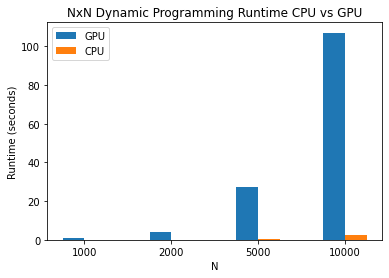

In [59]:
width = 0.25
plt.bar(np.arange(len(N_vals)) - 0.125, GPU_Times, width);
plt.bar(np.arange(len(N_vals)) + 0.125, CPU_Times, width);
plt.xticks(np.arange(len(N_vals)), N_vals);
plt.legend(["GPU", "CPU"]);
plt.title("NxN Dynamic Programming Runtime CPU vs GPU");
plt.ylabel("Runtime (seconds)");
plt.xlabel("N");

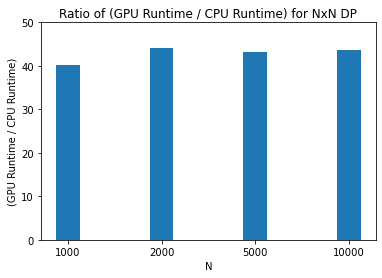

In [61]:
width = 0.25
plt.bar(np.arange(len(N_vals)), (np.array(GPU_Times) / np.array(CPU_Times)), width);
plt.ylim((0,50));
plt.xticks(np.arange(len(N_vals)), N_vals);
plt.title("Ratio of (GPU Runtime / CPU Runtime) for NxN DP");
plt.xlabel("N");
plt.ylabel("(GPU Runtime / CPU Runtime)");

# GPU Parallelization

In [8]:
K_vals = [1,2,4,8,16,32,64,128,256,512]

In [9]:
kThreadTimes = [1.04728, 1.04787, 1.05564, 1.07576, 1.10590, 1.19645, 1.23392, 1.30730, 2.62717, 8.78679]

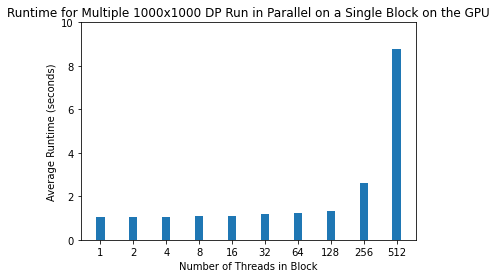

In [10]:
width = 0.25
plt.bar(np.arange(len(K_vals)), kThreadTimes, width);
plt.ylim((0,10));
plt.xticks(np.arange(len(K_vals)), K_vals);
plt.title("Runtime for Multiple 1000x1000 DP Run in Parallel on a Single Block on the GPU");
plt.xlabel("Number of Threads in Block");
plt.ylabel("Average Runtime (seconds)");

In [11]:
kBlockTimes =[1.0469, 1.05577, 1.04195, 1.04884, 1.03124, 1.05004, 1.07303, 1.16816, 1.50412, 2.96882]

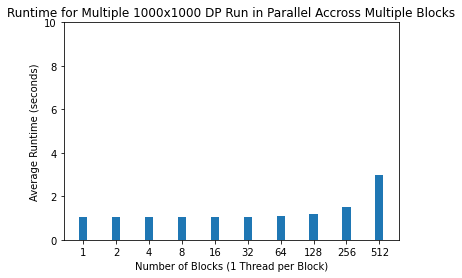

In [12]:
width = 0.25
plt.bar(np.arange(len(K_vals)), kBlockTimes, width);
plt.ylim((0,10));
plt.xticks(np.arange(len(K_vals)), K_vals);
plt.title("Runtime for Multiple 1000x1000 DP Run in Parallel Accross Multiple Blocks");
plt.xlabel("Number of Blocks (1 Thread per Block)");
plt.ylabel("Average Runtime (seconds)");

# Q3: M Subfragments

In [2]:
M_vals = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [3]:
mThreadTimes = [4.81771, 2.92108, 1.73987,  1.17764, 0.89125, 0.74425, 0.68187, 0.66386, 0.71644, 0.86654, 1.16960]

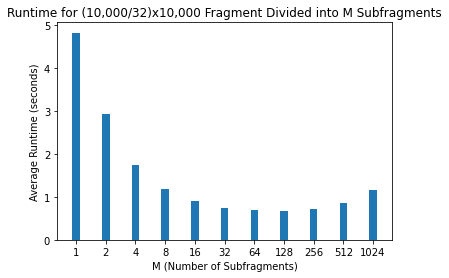

In [4]:
width = 0.25
plt.bar(np.arange(len(M_vals)), mThreadTimes, width);
# plt.ylim((0,10));
plt.xticks(np.arange(len(M_vals)), M_vals);
plt.title("Runtime for (10,000/32)x10,000 Fragment Divided into M Subfragments");
plt.xlabel("M (Number of Subfragments)");
plt.ylabel("Average Runtime (seconds)");

In [7]:
mBlockTimes = [4.67155, 2.53734, 1.40648, 0.84220, 0.55473, 0.42629, 0.34903, 0.32349, 0.33785, 0.59487, 1.31171]

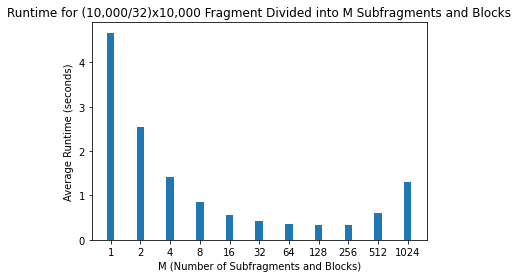

In [11]:
width = 0.25
plt.bar(np.arange(len(M_vals)), mBlockTimes, width);
# plt.ylim((0,10));
plt.xticks(np.arange(len(M_vals)), M_vals);
plt.title("Runtime for (10,000/32)x10,000 Fragment Divided into M Subfragments and Blocks");
plt.xlabel("M (Number of Subfragments and Blocks)");
plt.ylabel("Average Runtime (seconds)");

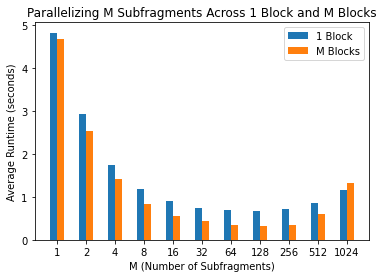

In [10]:
width = 0.25
plt.bar(np.arange(len(M_vals)) - 0.125, mThreadTimes, width);
plt.bar(np.arange(len(M_vals)) + 0.125, mBlockTimes, width);
# plt.ylim((0,10));
plt.xticks(np.arange(len(M_vals)), M_vals);
plt.title("Parallelizing M Subfragments Across 1 Block and M Blocks");
plt.legend(["1 Block", "M Blocks"])
plt.xlabel("M (Number of Subfragments)");
plt.ylabel("Average Runtime (seconds)");